In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.io import loadmat
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2
from typing import List, Tuple

In [2]:
KERNEL_SIZE = 17
CENTER = KERNEL_SIZE // 2
TRAJECTORIES_DIR = './trajectories'
PSF_DIR = './psf'
BLURRED_DIR = './blurred'
DEBLURRED_DIR = './deblurred'
mat = loadmat('100_motion_paths.mat')
X, Y = mat['X'], mat['Y']
NUM_EXAMPLES = X.shape[0]
orig_image = cv2.imread('DIPSourceHW1.jpg', cv2.IMREAD_GRAYSCALE).astype(np.uint8)

In [3]:
def save_trajectories(mat, output_folder: str = TRAJECTORIES_DIR):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, (x, y) in enumerate(zip(X, Y)):
        plt.plot(x, y)
        plt.title(f'Trajectory {i}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.savefig(f'{output_folder}/{i}.png')
        plt.close()

def plot_trajectories(mat):
    fig, axs = plt.subplots(10, 10, figsize=(12, 12))
    fig.suptitle('Trajectories')
    fig.set_layout_engine('tight')
    for i, j in np.ndindex(axs.shape):
        x, y = mat['X'][10*i + j], mat['Y'][10*i + j]
        axs[i, j].plot(x, y)
        axs[i, j].set_xticks([np.floor(x.min()), np.ceil(x.max())])
        axs[i, j].set_yticks([np.floor(y.min()), np.ceil(y.max())])
    plt.show()

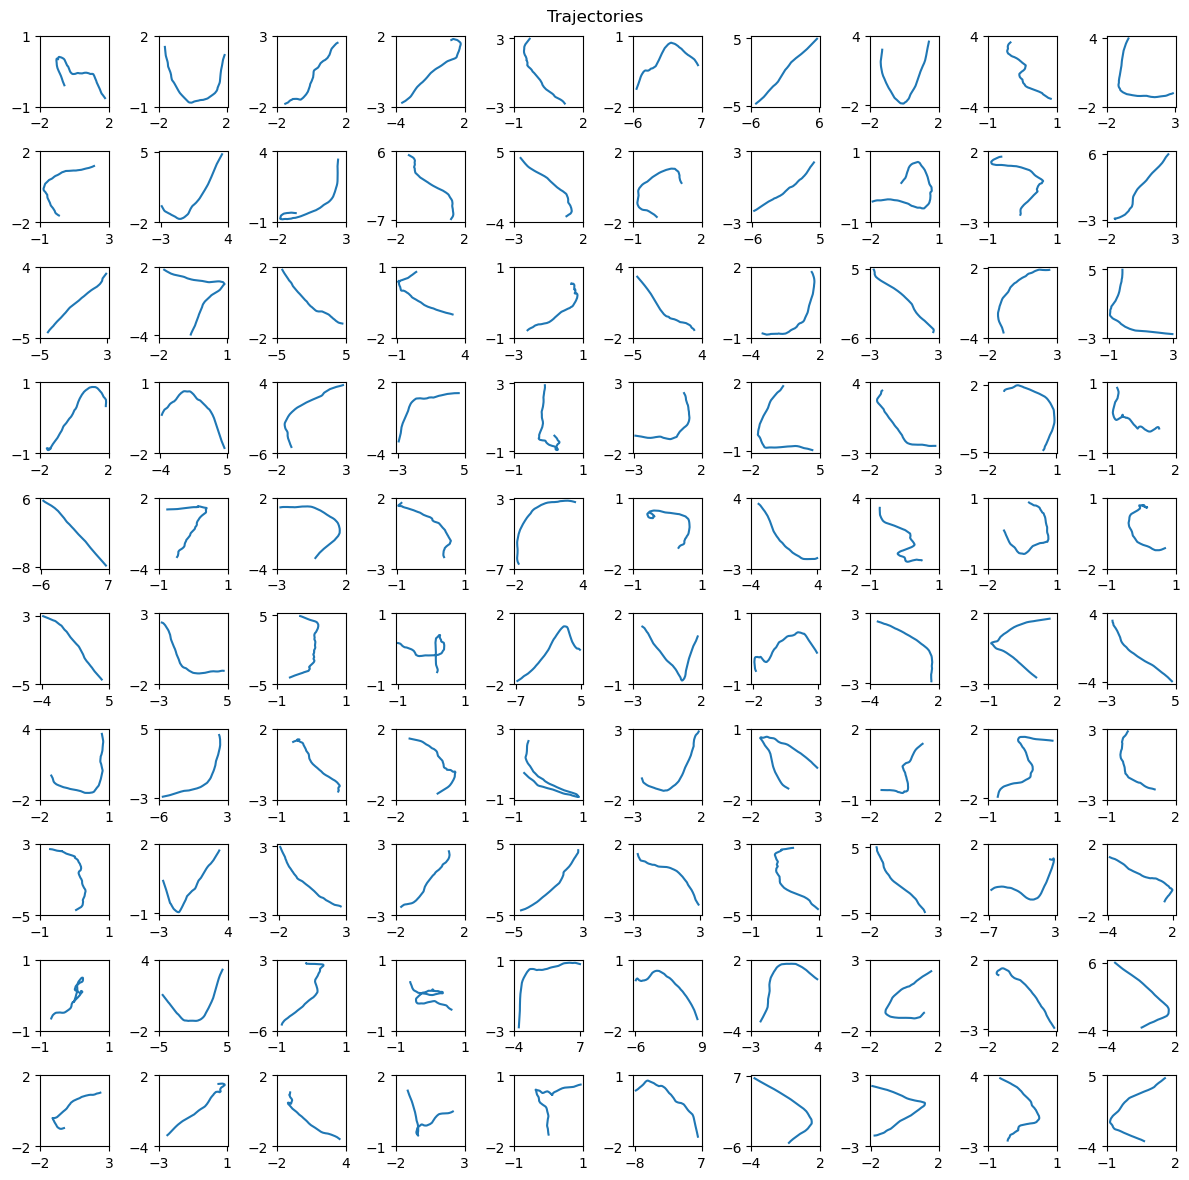

In [4]:
plot_trajectories(mat)

In [5]:
save_trajectories(mat)

In [6]:
def generate_psfs(X: np.ndarray, Y: np.ndarray, save_psf_figs: bool = False, output_folder: str = PSF_DIR) -> np.ndarray:
    # asserting save_psf_figs implies output_folder is not empty
    assert not save_psf_figs or output_folder

    psfs = np.zeros((NUM_EXAMPLES, KERNEL_SIZE, KERNEL_SIZE))
    for i in range(NUM_EXAMPLES):
        yvec = np.round(CENTER - Y[i]).astype(int)
        xvec = np.round(CENTER + X[i]).astype(int)
        for x, y in zip(xvec, yvec):
            if 0 <= x < KERNEL_SIZE and 0 <= y < KERNEL_SIZE:
                psfs[i, y, x] += 1

        if save_psf_figs:
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            cv2.imwrite(f'{output_folder}/{i}.png', psfs[i])

    # min-max scaling to [0, 255]
    psfs = (psfs - psfs.min()) / (psfs.max() - psfs.min()) * 255
    # return as 8-bit integer
    return psfs.astype(np.uint8)

def plot_psfs(psfs: np.ndarray):
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))
    fig.suptitle('Point Spread Functions')
    fig.set_layout_engine('tight')
    for i, j in np.ndindex(axs.shape):
        axs[i, j].imshow(psfs[10*i + j], cmap='gray')
        axs[i, j].axis('off')
    plt.show()

In [7]:
psfs = generate_psfs(X, Y, save_psf_figs=True)

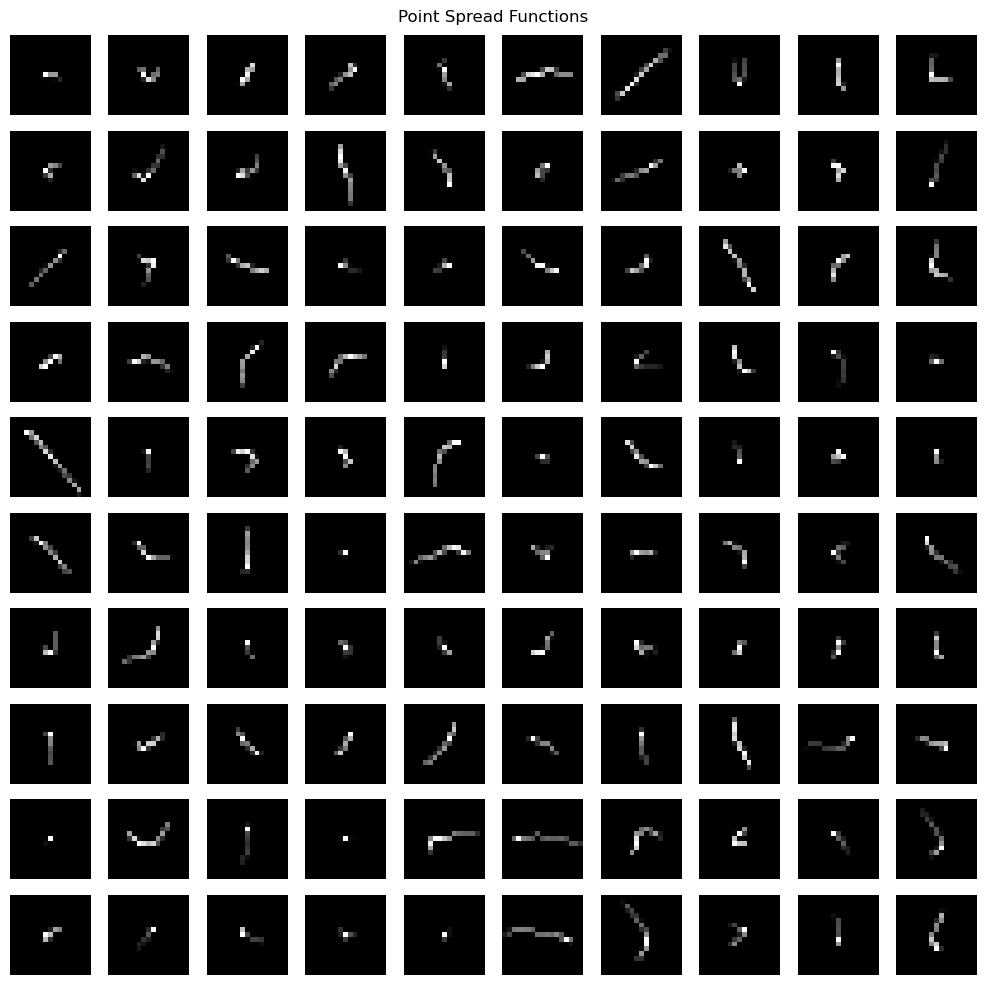

In [8]:
plot_psfs(psfs)

In [9]:
def generate_blurred(orig_image, psfs: np.ndarray, save_blurred_figs: bool = False, output_folder: str = BLURRED_DIR) -> List[np.ndarray]:
    assert not save_blurred_figs or output_folder, 'output_folder must be provided if save_blurred_figs is True'
    if save_blurred_figs and output_folder:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

    blurred_images = []
    for i, psf in enumerate(psfs):
        blurred_image = convolve2d(
            orig_image, psf / 255, boundary='symm', mode='same').clip(0, 255)
        blurred_images.append(blurred_image)
        if save_blurred_figs:
            cv2.imwrite(f'{output_folder}/{i}.png', blurred_image)
    return blurred_images

In [10]:
blurred_images = generate_blurred(orig_image, psfs, save_blurred_figs=True)

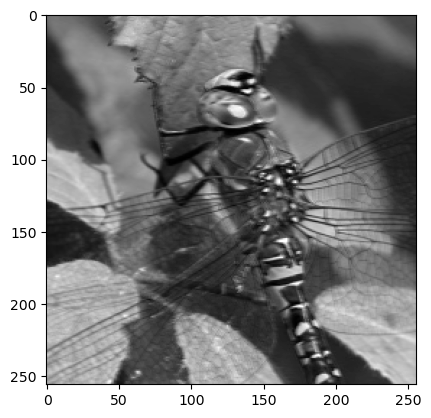

In [11]:
# Example of a blurred image
plt.imshow(blurred_images[0], cmap='gray')

In [12]:
def deblur(blurred_images: List[np.ndarray],
           orig_image: np.ndarray,
           *,
           sigma: float = 256.0 / KERNEL_SIZE,  # value suggested by the paper
           p: int = 11,                         # value suggested by the paper
           save_deblurred: bool = False,
           deblurred_output_folder: str = DEBLURRED_DIR,
           save_psnr_plot: bool = False,
           psnr_plot_path: str = 'psnr.png',
           verbose: bool = False) -> Tuple[np.ndarray, List[float]]:
    """
    Implementation of Fourier Burst Accumulation, according to the paper:
    "Removing Camera Shake via Weighted Fourier Burst Accumulation" by Delbracio and Sapiro
    Source: https://arxiv.org/pdf/1505.02731.pdf
    returns the deblurred image and the PSNR values for each iteration.
    """
    psnr_values = []
    # accumulated weights and frequencies
    w = np.zeros((256, 256), dtype=np.float64)
    u_hat = np.zeros((256, 256), dtype=np.complex128)
    for k, blurred_image in enumerate(blurred_images):
        f_image = fft.fft2(blurred_image)
        w_i_p = gaussian_filter(np.abs(f_image), sigma) ** p
        u_hat += w_i_p * f_image
        w += w_i_p

        # reconstructed image for the k-th iteration
        u_k = (fft.ifft2(u_hat / w)).real.astype(np.uint8)

        # calculate and save the PSNR value
        psnr_values.append(psnr(orig_image, u_k, data_range=255))

        # print the PSNR value
        if verbose and k % 10 == 0:
            print(f'k={k}, PSNR={psnr_values[-1]}')

        # save the deblurred image
        if save_deblurred:
            if not os.path.exists(DEBLURRED_DIR):
                os.makedirs(DEBLURRED_DIR)
            cv2.imwrite(f'{DEBLURRED_DIR}/{k}.png', u_k)

    # save the PSNR vs. num images plot
    if save_psnr_plot:
        plt.plot(psnr_values)
        plt.title('PSNR vs. Number of images')
        plt.xlabel('Number of images')
        plt.ylabel('PSNR')
        plt.grid()
        _ = plt.savefig(psnr_plot_path)
        plt.clf()
    # final deblurred image
    u = u_k
    return u, psnr_values

In [13]:
deblurred_image, psnr_values = deblur(blurred_images, orig_image, save_deblurred=True, save_psnr_plot=True)

<Figure size 640x480 with 0 Axes>

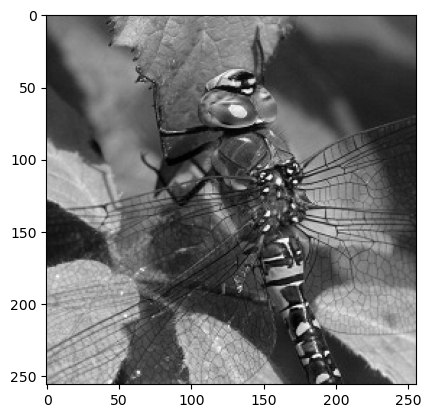

In [14]:
# Plot the final deblurred image
plt.imshow(deblurred_image, cmap='gray')

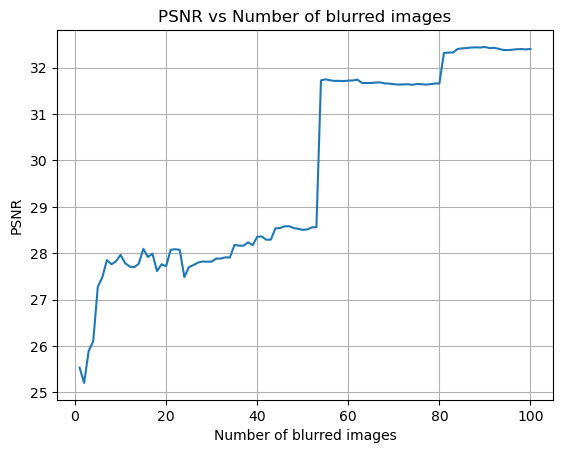

In [15]:
# Plot the PSNR values
plt.plot(range(1, NUM_EXAMPLES + 1), psnr_values)
plt.xlabel('Number of blurred images')
plt.ylabel('PSNR')
plt.title('PSNR vs Number of blurred images')
plt.grid()
plt.show()

In [16]:
# Save the PSNR values to file
with open('psnr_values.txt', 'w') as f:
    for psnr_value in psnr_values:
        f.write(f'{psnr_value}\n')